In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.lines as mlines
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm
import pickle
import numpy as np

import crflux.models as pm
import mceq_underground_helpers_cs as mh
from MCEq.data import InteractionCrossSections
from MCEq.core import MCEqRun
import  mceq_underground_helper_k_pi as helper
from scipy.optimize import curve_fit
from scipy.stats import linregress

In [2]:
X = helper.slant_depths[2:-1:4]

In [3]:
plot_dir = '/hetghome/khymon/Plots/cs-analysis/'

In [23]:
cs_p_values = [1.0,1.01] #[0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5]  # List of cross-section values: pion-air
cs_k_values = [1.00]
ptype_values = [2212] 
season_values = ["jan", "apr", "jul"]  #  seasons
e0_values = [2.05,2.15,2.25,2.35,2.45,2.55,2.65,2.75,2.85,2.95,3.05,3.15,3.25,3.35,3.45,3.55,3.65,3.75,3.85,3.95,4.05,4.15,4.25,4.35,4.45,4.55,4.65,4.75,4.85]
e1_values = [2.25,2.35,2.45,2.55,2.65,2.75,2.85,2.95,3.05,3.15,3.25,3.35,3.45,3.55,3.65,3.75,3.85,3.95,4.05,4.15,4.25,4.35,4.45,4.55,4.65,4.75,4.85,4.95,5.05]
e_center = e0_values + np.ones(len(e0_values))*0.1
pairwise = True


helper.initialize_flux_dicts(
        ptype_values, cs_p_values, cs_k_values, e0_values, e1_values if 'e1_values' in locals() else [None], pairwise=pairwise
) 

helper.some_function_that_uses_angles()
angles = helper.angles
X = helper.slant_depths[2:-1:4]

Key: (2212, 1.0, 1.0, 2.05, 'inf')
Length of cos_thetas: 6
Shape of flux for season jan: (6, 121)
Shape of flux for season apr: (6, 121)
Shape of flux for season jul: (6, 121)
Key: (2212, 1.01, 1.0, 2.05, 2.25)
Length of cos_thetas: 6
Shape of flux for season jan: (6, 121)
Shape of flux for season apr: (6, 121)
Shape of flux for season jul: (6, 121)
Key: (2212, 1.01, 1.0, 2.15, 2.35)
Length of cos_thetas: 6
Shape of flux for season jan: (6, 121)
Shape of flux for season apr: (6, 121)
Shape of flux for season jul: (6, 121)
Key: (2212, 1.01, 1.0, 2.25, 2.45)
Length of cos_thetas: 6
Shape of flux for season jan: (6, 121)
Shape of flux for season apr: (6, 121)
Shape of flux for season jul: (6, 121)
Key: (2212, 1.01, 1.0, 2.35, 2.55)
Length of cos_thetas: 6
Shape of flux for season jan: (6, 121)
Shape of flux for season apr: (6, 121)
Shape of flux for season jul: (6, 121)
Key: (2212, 1.01, 1.0, 2.45, 2.65)
Length of cos_thetas: 6
Shape of flux for season jan: (6, 121)
Shape of flux for seas

In [10]:
cs_p = 1.01
cs_k = 1.0
angle = 0.0
season = "apr"

In [5]:
def get_log_y(X, angle,cs_p,cs_k,e0,e1,season):
    log_y = np.log10(1e4*helper.mult_dist(X,
                            angle,
                            pm.GlobalSplineFitBeta(),"yields_" + season,
                            2212,
                            cs_p, cs_k,e0,e1,
                            norm=False#))[0]
                        ) / helper.rates(X, angle, season, 2212, cs_p, cs_k, e0,e1))

    return log_y

In [6]:
def get_derivative(x_log, log_y):

    deriv_low = (log_y[19] - log_y[1])/(np.log10(x_log[19])-np.log10(x_log[1])) 
    deriv_high = (log_y[99] - log_y[59])/(np.log10(x_log[99])-np.log10(x_log[59])) 

    return deriv_low, deriv_high

In [7]:
x_log = np.log10(helper.n_mu_vec)

In [ ]:
y_log_test = get_log_y(X[0], angle, cs_p, cs_k ,3.25,3.45,"apr")

In [42]:
deriv_mod_15 =np.ndarray(shape=(len(e0_values),2))
deriv_mod_35 =np.ndarray(shape=(len(e0_values),2))
for en in range(len(e0_values)):
    logy_15 = get_log_y(X[0], angle, cs_p, cs_k ,e0_values[en],e1_values[en],season)
    deriv_mod_15[en] = get_derivative(x_log, logy_15)

    logy_35 = get_log_y(X[1], angle, cs_p, cs_k ,e0_values[en],e1_values[en],season)
    deriv_mod_35[en] = get_derivative(x_log, logy_15)

y_log_def = get_log_y(X[0], angle, 1.0, cs_k ,2.05,"inf",season)
deriv_def = get_derivative(x_log, y_log_def)


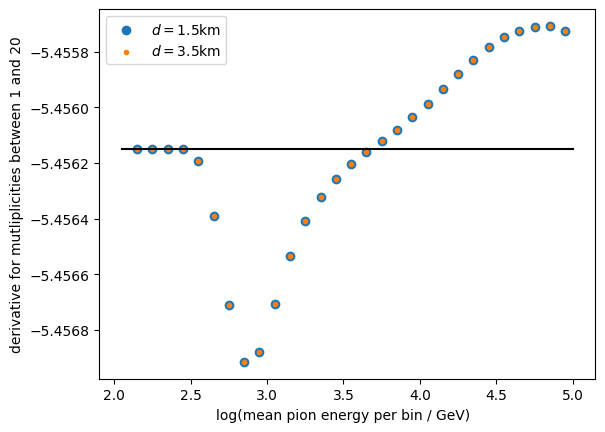

In [45]:
plt.scatter(e_center,deriv_mod_15[:,0],label="$d=1.5$km")
plt.scatter(e_center,deriv_mod_35[:,0],label="$d=3.5$km",marker='.')
plt.plot([2.05,5],[deriv_def[0],deriv_def[0]],color='black')
plt.ylabel('derivative for mutliplicities between 1 and 20')
plt.xlabel('log(mean pion energy per bin / GeV)  ')
plt.legend()
plt.savefig(plot_dir + 'cs_p_energybintest_powerlawderiv_lowregion_ebin.png')

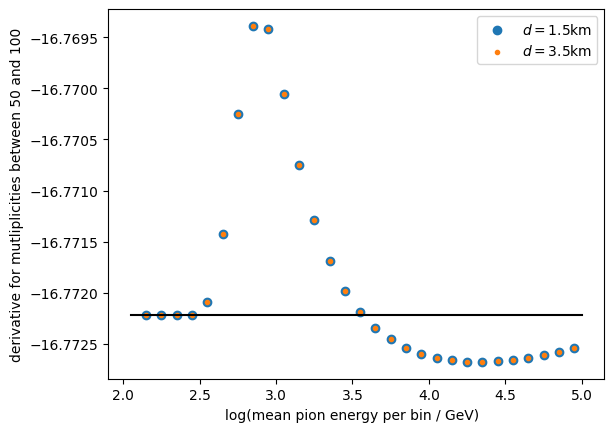

In [46]:
plt.scatter(e_center,deriv_mod_15[:,1],label="$d=1.5$km")
plt.scatter(e_center,deriv_mod_35[:,1],label="$d=3.5$km",marker='.')
plt.plot([2.05,5],[deriv_def[1],deriv_def[1]],color='black')
plt.ylabel('derivative for mutliplicities between 50 and 100')
plt.xlabel('log(mean pion energy per bin / GeV)  ')
plt.legend()
plt.savefig(plot_dir + 'cs_p_energybintest_powerlawderiv_highregion_ebin.png')

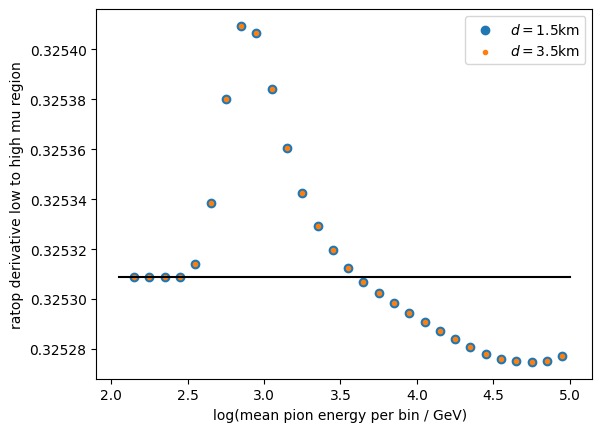

In [49]:
plt.scatter(e_center,deriv_mod_15[:,0]/deriv_mod_15[:,1],label="$d=1.5$km")
plt.scatter(e_center,deriv_mod_35[:,0]/deriv_mod_35[:,1],label="$d=3.5$km",marker='.')
plt.plot([2.05,5],[deriv_def[0]/deriv_def[1],deriv_def[0]/deriv_def[1]],color='black')
plt.ylabel('ratop derivative low to high mu region')
plt.xlabel('log(mean pion energy per bin / GeV)  ')
plt.legend()
plt.savefig(plot_dir + 'cs_p_energybintest_powerlawderiv_ratio_ebin.png')

In [48]:
deriv_mod_15[:,0]/deriv_mod_15[:,1]

array([0.32530878, 0.32530878, 0.32530879, 0.32530877, 0.32531389,
       0.32533847, 0.32538027, 0.32540936, 0.32540659, 0.32538392,
       0.3253603 , 0.32534232, 0.32532926, 0.32531973, 0.32531257,
       0.32530697, 0.32530238, 0.32529834, 0.32529457, 0.32529093,
       0.32528734, 0.32528385, 0.32528063, 0.32527793, 0.3252761 ,
       0.32527517, 0.32527484, 0.32527532, 0.32527727])